In [1]:
import pandas as pd 
import numpy as np 
import random
from datetime import datetime, timedelta

In [2]:


# Parameters
n_users = 10000
today = datetime.today()


def random_date(start, end):
    return start + timedelta(days=random.randint(0, (end-start).days))


data = {
    "user_id": [f"user_{i}" for i in range(1, n_users+1)],
    "cart_abandoned_date": [today - timedelta(days=random.randint(0, 10)) for _ in range(n_users)],
    "last_order_date": [today - timedelta(days=random.randint(5, 200)) for _ in range(n_users)],
    "avg_order_value": np.random.randint(200, 6000, size=n_users),  # INR
    "sessions_last_30d": np.random.poisson(5, size=n_users),  # Poisson dist for session counts
    "num_cart_items": np.random.randint(1, 10, size=n_users),
    "engagement_score": np.round(np.random.uniform(0, 1, size=n_users), 2),
    "profitability_score": np.round(np.random.uniform(0, 1, size=n_users), 2),
}

df = pd.DataFrame(data)

print("Sample Data:")
df.head()


Sample Data:


,user_id,cart_abandoned_date,last_order_date,avg_order_value,sessions_last_30d,num_cart_items,engagement_score,profitability_score
0,user_1,2025-09-18 23:26:55.769076,2025-04-28 23:26:55.769076,4183,5,1,0.70,0.19
1,user_2,2025-09-16 23:26:55.769076,2025-08-06 23:26:55.769076,889,2,6,0.54,0.29
2,user_3,2025-09-17 23:26:55.769076,2025-03-09 23:26:55.769076,2098,9,4,0.75,0.05
3,user_4,2025-09-09 23:26:55.769076,2025-07-22 23:26:55.769076,2591,11,5,0.85,0.49
4,user_5,2025-09-16 23:26:55.769076,2025-04-07 23:26:55.769076,5958,5,7,0.14,0.25


In [4]:
# (Cart abandoners in last 7 days)
universe_df = df[df['cart_abandoned_date'] >= today - timedelta(days=7)]

print(f"Total Users in Universe: {len(universe_df)}")
universe_df.head()


Total Users in Universe: 7299


,user_id,cart_abandoned_date,last_order_date,avg_order_value,sessions_last_30d,num_cart_items,engagement_score,profitability_score
0,user_1,2025-09-18 23:26:55.769076,2025-04-28 23:26:55.769076,4183,5,1,0.70,0.19
1,user_2,2025-09-16 23:26:55.769076,2025-08-06 23:26:55.769076,889,2,6,0.54,0.29
2,user_3,2025-09-17 23:26:55.769076,2025-03-09 23:26:55.769076,2098,9,4,0.75,0.05
4,user_5,2025-09-16 23:26:55.769076,2025-04-07 23:26:55.769076,5958,5,7,0.14,0.25
5,user_6,2025-09-12 23:26:55.769076,2025-07-13 23:26:55.769076,287,2,4,0.17,0.33


In [16]:
# Block 4 (fixed): Segmentation Logic with explicit columns

def segment_user(row):
    # AOV Segment
    if row["avg_order_value"] > 3000:
        aov_seg = "High"
    elif row["avg_order_value"] > 1000:
        aov_seg = "Mid"
    else:
        aov_seg = "Low"
        
    # Engagement Segment
    if row["engagement_score"] > 0.7:
        eng_seg = "High"
    elif row["engagement_score"] > 0.4:
        eng_seg = "Mid"
    else:
        eng_seg = "Low"
        
    # Profitability Segment
    if row["profitability_score"] > 0.7:
        prof_seg = "High"
    elif row["profitability_score"] > 0.4:
        prof_seg = "Mid"
    else:
        prof_seg = "Low"
    
    return pd.Series([aov_seg, eng_seg, prof_seg])

# Apply segmentation
universe_df[["aov_segment", "engagement_segment", "profitability_segment"]] = universe_df.apply(segment_user, axis=1)


/var/folders/55/mhy5dtxs1g11qqd33n2hv53h0000gn/T/ipykernel_76467/1995346480.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  universe_df[["aov_segment", "engagement_segment", "profitability_segment"]] = universe_df.apply(segment_user, axis=1)
/var/folders/55/mhy5dtxs1g11qqd33n2hv53h0000gn/T/ipykernel_76467/1995346480.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  universe_df[["aov_segment", "engagement_segment", "profitability_segment"]] = universe_df.apply(segment_user, axis=1)
/var/folders/55/mh

In [17]:
# Block 5: Enforce Constraints

MIN_SIZE = 500
MAX_SIZE = 20000

# Check sizes
segment_sizes = universe_df['segment'].value_counts().to_dict()

# Map small segments to "Other"
def apply_constraints(seg):
    size = segment_sizes.get(seg, 0)
    if size < MIN_SIZE or size > MAX_SIZE:
        return "Other"
    return seg

universe_df['final_segment'] = universe_df['segment'].apply(apply_constraints)

# Updated distribution
final_distribution = universe_df['final_segment'].value_counts().reset_index()
final_distribution.columns = ["Final Segment", "Size"]

print("Final Segment Distribution (after constraints):")
final_distribution


Final Segment Distribution (after constraints):


/var/folders/55/mhy5dtxs1g11qqd33n2hv53h0000gn/T/ipykernel_76467/1092455950.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  universe_df['final_segment'] = universe_df['segment'].apply(apply_constraints)


,Final Segment,Size
0,Other,1005
1,High AOV_HighEng_HighProf,980
2,High AOV_LowEng_HighProf,971
3,High AOV_HighEng_LowProf,911
4,High AOV_LowEng_LowProf,910
5,Mid AOV_HighEng_HighProf,714
6,Mid AOV_LowEng_HighProf,643
7,Mid AOV_HighEng_LowProf,602
8,Mid AOV_LowEng_LowProf,563


In [18]:
# Block 6: Calculate Priority Score

# Normalize AOV so it fits 0–1 scale (like engagement/profitability)
universe_df["aov_norm"] = (universe_df["avg_order_value"] - universe_df["avg_order_value"].min()) / \
                          (universe_df["avg_order_value"].max() - universe_df["avg_order_value"].min())

# Weighted score
universe_df["priority_score"] = (
    0.4 * universe_df["aov_norm"] +
    0.3 * universe_df["engagement_score"] +
    0.3 * universe_df["profitability_score"]
)

# Sort users by score (descending)
priority_df = universe_df.sort_values("priority_score", ascending=False)

print("Top Prioritized Users:")
priority_df.head()


Top Prioritized Users:


/var/folders/55/mhy5dtxs1g11qqd33n2hv53h0000gn/T/ipykernel_76467/3465445800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  universe_df["aov_norm"] = (universe_df["avg_order_value"] - universe_df["avg_order_value"].min()) / \
/var/folders/55/mhy5dtxs1g11qqd33n2hv53h0000gn/T/ipykernel_76467/3465445800.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  universe_df["priority_score"] = (


,user_id,cart_abandoned_date,last_order_date,avg_order_value,sessions_last_30d,num_cart_items,engagement_score,profitability_score,segment,final_segment,aov_norm,priority_score,aov_segment,engagement_segment,profitability_segment
9689,user_9690,2025-09-14 23:26:55.769076,2025-09-10 23:26:55.769076,5929,6,4,0.99,0.94,High AOV_HighEng_HighProf,High AOV_HighEng_HighProf,0.987929,0.974172,High,High,High
1865,user_1866,2025-09-13 23:26:55.769076,2025-04-05 23:26:55.769076,5828,1,1,0.95,0.98,High AOV_HighEng_HighProf,High AOV_HighEng_HighProf,0.970512,0.967205,High,High,High
7261,user_7262,2025-09-12 23:26:55.769076,2025-06-04 23:26:55.769076,5961,4,3,0.89,0.98,High AOV_HighEng_HighProf,High AOV_HighEng_HighProf,0.993447,0.958379,High,High,High
1370,user_1371,2025-09-14 23:26:55.769076,2025-07-27 23:26:55.769076,5779,5,4,1.00,0.89,High AOV_HighEng_HighProf,High AOV_HighEng_HighProf,0.962062,0.951825,High,High,High
1443,user_1444,2025-09-16 23:26:55.769076,2025-07-30 23:26:55.769076,5931,2,6,0.92,0.91,High AOV_HighEng_HighProf,High AOV_HighEng_HighProf,0.988274,0.944310,High,High,High


In [19]:
# Block 7: Create Priority Tiers

# Quantiles
q80 = priority_df["priority_score"].quantile(0.80)
q50 = priority_df["priority_score"].quantile(0.50)

def assign_tier(score):
    if score >= q80:
        return "Tier 1"
    elif score >= q50:
        return "Tier 2"
    else:
        return "Tier 3"

priority_df["priority_tier"] = priority_df["priority_score"].apply(assign_tier)

priority_df[["user_id", "avg_order_value", "engagement_score", 
             "profitability_score", "priority_score", "priority_tier"]].head(10)


,user_id,avg_order_value,engagement_score,profitability_score,priority_score,priority_tier
9689,user_9690,5929,0.99,0.94,0.974172,Tier 1
1865,user_1866,5828,0.95,0.98,0.967205,Tier 1
7261,user_7262,5961,0.89,0.98,0.958379,Tier 1
1370,user_1371,5779,1.00,0.89,0.951825,Tier 1
1443,user_1444,5931,0.92,0.91,0.944310,Tier 1
5294,user_5295,5503,0.94,0.98,0.941787,Tier 1
7704,user_7705,5648,0.97,0.91,0.939789,Tier 1
6087,user_6088,5265,0.99,0.95,0.931371,Tier 1
2560,user_2561,5978,0.86,0.91,0.929551,Tier 1
4356,user_4357,5658,0.99,0.85,0.928479,Tier 1


In [20]:
# Block 8: CRM Action Plan

def crm_action(tier, engagement, profitability):
    if tier == "Tier 1":
        # High priority = aggressive action
        if engagement == "High" and profitability == "High":
            return "Offer exclusive loyalty rewards + limited-time discount"
        elif engagement == "High":
            return "Send personalized reminders + extra free delivery"
        else:
            return "Push time-bound coupon + app notification"
    
    elif tier == "Tier 2":
        # Medium priority = balanced effort
        if profitability == "High":
            return "Send targeted email campaign with product recommendations"
        else:
            return "Send app/web push notification with gentle nudge"
    
    else:  # Tier 3
        # Low priority = low cost interventions
        return "Include in newsletter drip or retarget via ads"

priority_df["crm_action"] = priority_df.apply(
    lambda x: crm_action(x["priority_tier"], x["engagement_segment"], x["profitability_segment"]), axis=1
)

priority_df[["user_id", "priority_tier", "aov_segment", 
             "engagement_segment", "profitability_segment", "crm_action"]].head(10)



,user_id,priority_tier,aov_segment,engagement_segment,profitability_segment,crm_action
9689,user_9690,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
1865,user_1866,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
7261,user_7262,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
1370,user_1371,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
1443,user_1444,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
5294,user_5295,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
7704,user_7705,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
6087,user_6088,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
2560,user_2561,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...
4356,user_4357,Tier 1,High,High,High,Offer exclusive loyalty rewards + limited-time...


In [21]:

# Block 9: Summary Report

summary = priority_df.groupby(["priority_tier", "crm_action"]).size().reset_index(name="user_count")
summary


,priority_tier,crm_action,user_count
0,Tier 1,Offer exclusive loyalty rewards + limited-time...,408
1,Tier 1,Push time-bound coupon + app notification,628
2,Tier 1,Send personalized reminders + extra free delivery,424
3,Tier 2,Send app/web push notification with gentle nudge,1391
4,Tier 2,Send targeted email campaign with product reco...,799
5,Tier 3,Include in newsletter drip or retarget via ads,3649


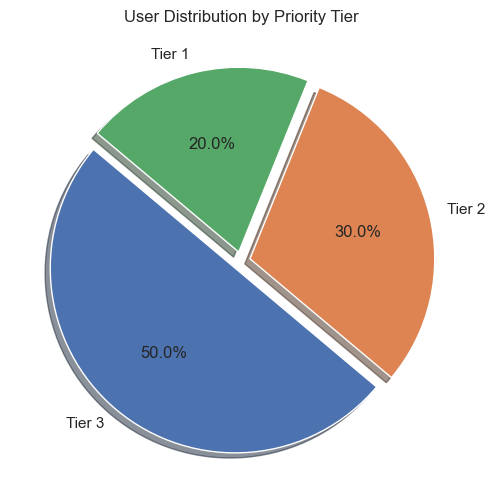

In [22]:
# Block 10: Tier Distribution Pie Chart
import matplotlib.pyplot as plt

tier_counts = priority_df["priority_tier"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    tier_counts, 
    labels=tier_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    explode=[0.05, 0.05, 0.05], 
    shadow=True
)
plt.title("User Distribution by Priority Tier")
plt.show()


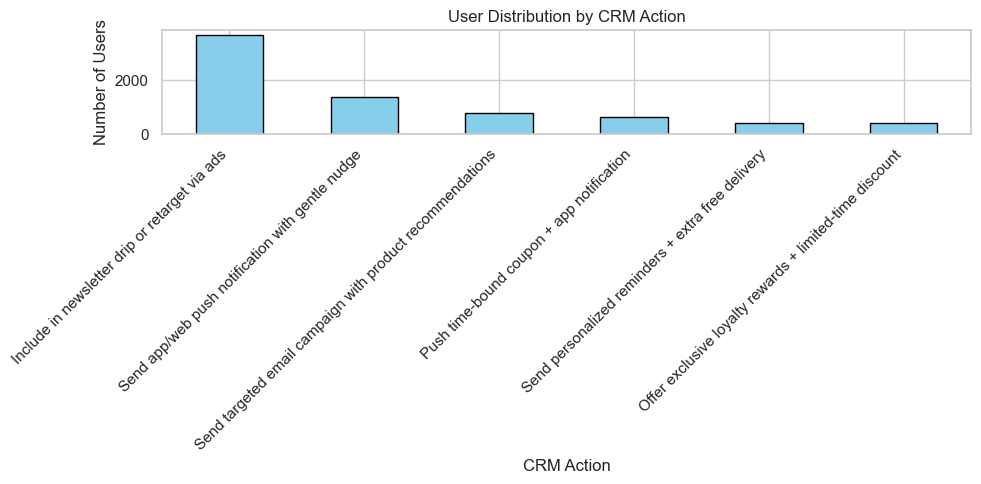

In [23]:
# Block 11: CRM Action Distribution
action_counts = priority_df["crm_action"].value_counts()

plt.figure(figsize=(10,5))
action_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("User Distribution by CRM Action")
plt.xlabel("CRM Action")
plt.ylabel("Number of Users")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
